### Installing packages

In [3]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install geopandas
!pip install shapely

^C
ERROR: Operation cancelled by user


In [ ]:
!pip install pdfminer.six


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


### Scraping data from pdfs

In [ ]:
import pandas as pd
import re
from pdfminer.high_level import extract_text, LAParams

Cleaning pdf

In [ ]:
text = extract_text("oct22.pdf", laparams = LAParams(boxes_flow=None))
print(text)

TOMPKINS COUNTY SHERIFFS
OFFICE
Public Information Log

Domestic

Incident Address:  ENFIELD FALLS RD; T ITHACA

ITHACA NY 14850

Time Reported:  23:32:09

Time Occurred Between:  23:32:09 10/31/22 - 23:34:07 10/31/22

Traffic Offense

Incident Address:  BLOCK TRUMANSBURG RD; T ITHACA

ITHACA NY 14850

Time Reported:  23:19:50

Time Occurred Between:  23:19:50 10/31/22 - 23:19:50 10/31/22

Traffic Offense

Incident Address:  STATE ROUTE 13 & WILLOW AVE; C ITHACA

ITHACA NY 14850

Time Reported:  23:09:41

Time Occurred Between:  23:09:41 10/31/22 - 23:09:41 10/31/22

Traffic Stop

Alarm Police

Incident Address:  PLEASANT VALLEY RD; T GROTON
GROTON NY 13073

Time Reported:  23:04:56

Time Occurred Between:  23:04:56 10/31/22 - 23:06:10 10/31/22

Alarm activation

Traffic Offense

Incident Address:  STATE ROUTE 13 N & N TRIPHAMMER RD; V LANSING

ITHACA NY 14850

Time Reported:  22:55:28

Time Occurred Between:  22:55:28 10/31/22 - 22:55:28 10/31/22

11/01/22

Public Information Log

Tr

In [ ]:
ts = text.split('\n')
ts = [i for i in ts if i != '']

f = open('clean.txt', 'w')
for i in ts:
    # remove hex characters
    line = re.sub(r'[^\x00-\x7f]',r'', i) 

    # heuristical skipping
    if i in ['TOMPKINS COUNTY SHERIFFS','OFFICE', 'Public Information Log', 'Public Information Log']:
        continue
    if i[:4] == 'Page':
        continue
    if i[0].isdigit():
        continue
            
    print(line, file=f)

f.close()

Need to process some things manually after - very first reason doesn't appear for some reason

In [ ]:
reasons = []
incident_address = []
time_reported = []
time_occured = []
comments = []

if_last_is_incident = False
if_last_time_occured = True

tot = ""
prev = ""
with open('clean.txt', 'r') as f:
    for ind, line in enumerate(f.readlines()):
        line = line.strip()
        
        first_colon = line.find(':')

        # heuristic adding to 
        if first_colon != -1:
            before = line[:first_colon]
            after = line[first_colon + 1:]
            if before == 'Incident Address':
                
                # append previous comments if not start as well as next reason
                if ind != 1:
                    comments.append(tot)
                reasons.append(prev)
                tot = ""
                prev = ""
                if_last_time_occured = False


                incident_address.append(after)

                if_last_is_incident = True

            elif before == 'Time Reported':
                if_last_is_incident = False
                time_reported.append(after)
            elif before == 'Time Occurred Between':
                time_occured.append(after)
                if_last_time_occured = True
        else:
            if if_last_is_incident:
                # Add to address
                incident_address[-1] += ' ' + line
            elif if_last_time_occured:
                tot += " " + prev
                prev = line
            # if first line
            elif ind == 0:
                prev = line

            else:
                pass
    comments.append(tot)
len(incident_address), len(time_reported), len(time_occured), len(reasons), len(comments)

(1841, 1841, 1841, 1841, 1841)

In [ ]:
df = pd.DataFrame.from_dict({
    'reasons' : reasons,
    'time_occured' : time_occured,
    'time_reported' : time_reported,
    'comments' : comments,
    'incident_address' : incident_address
})


In [ ]:
df.to_csv('oct22_cleaned.csv')

Cleaning csvs

In [ ]:
f = pd.read_csv('oct22accidents.csv')

In [ ]:
f.columns = f.iloc[1]

In [ ]:
f.dropna(how='all', axis=1, inplace=True)

In [ ]:
f.drop([0,1], inplace=True)
f.to_csv('clean.csv')

In [ ]:
f.to_csv('accidents_cleaned.csv')

Getting location from csvs

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env.
key = os.environ.get("API_KEY")

import requests
from urllib.parse import quote

def loc(street):
    addy = street
    
    addy = quote(addy)
    response = requests.get(f'https://maps.googleapis.com/maps/api/geocode/json?address={addy}&key={key}')
    resp_json_payload = response.json()
    print(resp_json_payload)
    return resp_json_payload['results'][0]['geometry']['location']['lat'], resp_json_payload['results'][0]['geometry']['location']['lng']

loc('MAIN ST & KIRK RD 13062')

{'results': [], 'status': 'ZERO_RESULTS'}


IndexError: list index out of range

In [ ]:
lat = []
long = []

for i in incident_address:
    s = i.split(';')
    print(s)
    if len(s) > 1:
        c = s[0] + ' '+ s[-1][-5:]
    else:
        c = s[0] + ' Tompkins County NY'

    print(c)
    try:
        location = loc(c)
        lat.append(location[0])
        long.append(location[1])
    except:
        lat.append("")
        long.append("")

        


['ENFIELD FALLS RD', ' T ITHACA ITHACA NY 14850']
ENFIELD FALLS RD 14850
{'results': [{'address_components': [{'long_name': 'Enfield Falls Road', 'short_name': 'Enfield Falls Rd', 'types': ['route']}, {'long_name': 'Ithaca', 'short_name': 'Ithaca', 'types': ['locality', 'political']}, {'long_name': 'Tompkins County', 'short_name': 'Tompkins County', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'New York', 'short_name': 'NY', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'United States', 'short_name': 'US', 'types': ['country', 'political']}, {'long_name': '14850', 'short_name': '14850', 'types': ['postal_code']}], 'formatted_address': 'Enfield Falls Rd, Ithaca, NY 14850, USA', 'geometry': {'bounds': {'northeast': {'lat': 42.41492590000003, 'lng': -76.5461474}, 'southwest': {'lat': 42.40030799999997, 'lng': -76.620048}}, 'location': {'lat': 42.4061947, 'lng': -76.5822069}, 'location_type': 'GEOMETRIC_CENTER', 'viewport': {'northeast': {'l

In [ ]:
df = pd.DataFrame.from_dict({
    'reasons' : reasons,
    'time_occured' : time_occured,
    'time_reported' : time_reported,
    'comments' : comments,
    'incident_address' : incident_address,
    'lat' : lat,
    'long' : long
})
df = df[df['reasons'].str.contains('Traffic')]
df = df[df['lat'] != '']

df.to_csv('traffic_only_oct_22.csv')

### Getting coords for Tompkins County

In [ ]:
import json

with open('tompkins-county-coords.json', 'r') as f:
    coords = json.load(f)
coords = coords['coordinates'][0]
coords = [(i,j) for i,j in coords]
coords

[(-76.585989, 42.54991),
 (-76.586538, 42.550175),
 (-76.588873, 42.551303),
 (-76.593778, 42.553668),
 (-76.597834, 42.555596),
 (-76.600887, 42.557047),
 (-76.603346, 42.558188),
 (-76.605987, 42.559413),
 (-76.606694, 42.559808),
 (-76.612027, 42.562783),
 (-76.612174, 42.562865),
 (-76.616286, 42.565432),
 (-76.616696, 42.565688),
 (-76.618239, 42.566652),
 (-76.622875, 42.570692),
 (-76.624439, 42.572055),
 (-76.624667, 42.572253),
 (-76.626761, 42.573868),
 (-76.629357, 42.576273),
 (-76.632496, 42.579182),
 (-76.638075, 42.584404),
 (-76.639216, 42.585472),
 (-76.644424, 42.590795),
 (-76.645317, 42.591708),
 (-76.647666, 42.594419),
 (-76.649649, 42.596708),
 (-76.650231, 42.597379),
 (-76.651716, 42.599216),
 (-76.654228, 42.602325),
 (-76.656226, 42.604798),
 (-76.658634, 42.608413),
 (-76.660242, 42.610827),
 (-76.663139, 42.616354),
 (-76.663556, 42.617149),
 (-76.666543, 42.623457),
 (-76.646243, 42.624292),
 (-76.646039, 42.624294),
 (-76.645709, 42.624304),
 (-76.645507,

Plotting coords

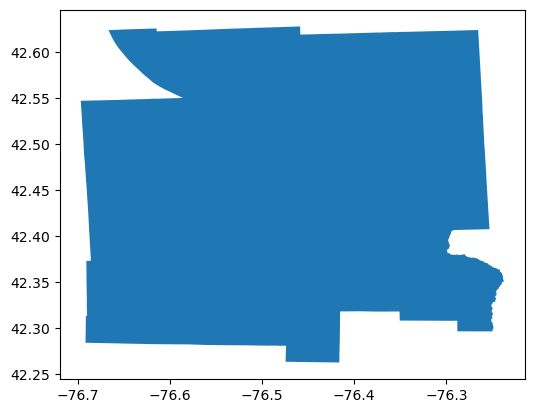

In [ ]:

from shapely import geometry
import matplotlib.pyplot as plt
import geopandas as gpd

tompkinscounty = geometry.Polygon(coords)

p = gpd.GeoSeries(tompkinscounty)
p.plot()
plt.show()

In [ ]:
x, y  = [i for i, _ in coords], [j for _,j in coords]
up_right_corner = max(x), max(y)
down_left_corner = min(x), min(y)

up_right_corner, down_left_corner

((-76.237695, 42.627419), (-76.696655, 42.262976))

In [ ]:
import numpy as np
def gen_random_point_in_polygon(polygon):
    rand_x = np.random.uniform(down_left_corner[0], up_right_corner[0])
    rand_y = np.random.uniform(down_left_corner[1], up_right_corner[1])

    rand_point = geometry.Point(rand_x, rand_y)
    if polygon.contains(rand_point):
        return rand_point
    else:
        return gen_random_point_in_polygon(polygon)

AttributeError: 'DataFrame' object has no attribute 'crs'

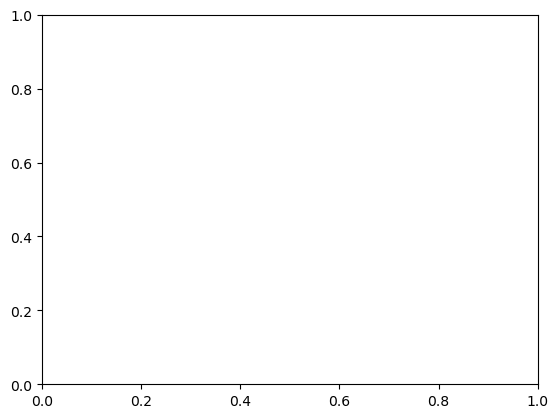

In [ ]:
sample_rand_point = gen_random_point_in_polygon(tompkinscounty)

p = gpd.GeoDataFrame([tompkinscounty, sample_rand_point])
p.plot()
plt.show()

### Plotting accidents on Tompkins County Map

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
bbox = (-76.6967, -76.2377, 42.2630, 42.6274)
ruh_m = plt.imread('tompkins_county.png')
df = pd.read_csv('whole_with_time.csv')

df['time_started'] = pd.to_datetime(df['time_started'])

In [7]:
# Data Processing step

def proc_reasons(df):
    if 'traffic stop' in df.lower():
        return "Traffic Offense"
    elif 'traffic cmplnt' in df.lower() or 'traffic complaint' in df.lower():
        return "Traffic Complaint"
    elif 'traffic offense' in df.lower() or 'traffic collision' in df.lower():
        return 'Traffic Offense'
    else:
        return ""

df['reasons_processed'] = df['reasons'].apply(proc_reasons)

In [8]:
import plotly.express as px

fig = px.scatter_mapbox(df,lat='lat',lon='long', color="reasons_processed")
fig.update_layout(mapbox_style = 'open-street-map', title_x=0.5)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


# import plotly.express as px

# px.set_mapbox_access_token(open(".mapbox_token").read())
# fig = px.scatter_mapbox(df,lat='lat',lon='long', color="reasons")
# # fig.update_layout(title = 'World map', title_x=0.5)
# fig.show()

In [9]:

df['month'] = df['time_started'].dt.month
df['hour'] = df['time_started'].dt.hour
df['time_processed'] = df['time_started'].dt.time

df['time_started']

0      2021-07-31 21:44:56
1      2021-07-31 18:07:24
2      2021-07-31 17:30:55
3      2021-07-31 17:16:25
4      2021-07-31 01:40:20
               ...        
6746   2021-10-01 02:28:10
6747   2021-10-01 02:28:10
6748   2021-10-01 02:28:10
6749   2021-10-01 01:33:29
6750   2021-10-01 01:03:37
Name: time_started, Length: 6751, dtype: datetime64[ns]

In [10]:

fig = px.scatter_mapbox(df,lat='lat',lon='long', color='hour')
fig.update_layout(mapbox_style = 'open-street-map', title_x=0.5)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

(42.262976, 42.627419)

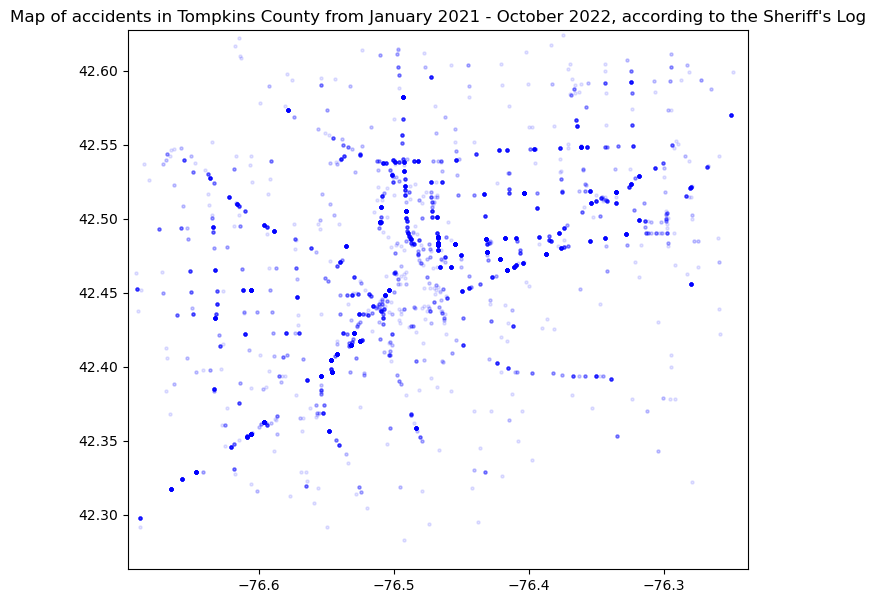

In [11]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df.long, df.lat , zorder=1, alpha= 0.1, c='b', s=5)

bbox = (-76.696655, -76.237695,  42.262976, 42.627419)
ax.set_title('Map of accidents in Tompkins County from January 2021 - October 2022, according to the Sheriff\'s Log')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
# ax.imshow(ruh_m, zorder=0, extent = bbox, aspect= 'equal')

In [12]:
fig, ax = plt.subplots(figsize = (8,7))
# tdddf = df[df['time_started']]

bbox = 
ax.scatter(df.long, df.lat, zorder=1, alpha= 0.1, c='b', s=5)
ax.set_title('Map of traffic reports in Tompkins County from January 2021 - October 2022, according to the Sheriff\'s Log')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.imshow(ruh_m, zorder=0, extent = bbox, aspect= 'equal')

SyntaxError: invalid syntax (703430133.py, line 4)

In [13]:
import datetime

start = datetime.time(23, 0, 0)
end = datetime.time(1, 0, 0)

df['time_started'] = pd.to_datetime(df['time_started'])
tdf = df[(df['time_started'].dt.time <= end) | (df['time_started'].dt.time >= start)]
tdf

Unnamed: 0          reasons                           time_occured  \
5              5  Traffic Offense  00:28:31 07/31/21 - 00:28:31 07/31/21   
6              6  Traffic Offense  00:26:19 07/31/21 - 00:26:19 07/31/21   
7              7  Traffic Offense  00:23:06 07/31/21 - 00:23:06 07/31/21   
23            23  Traffic Offense  00:42:06 07/28/21 - 00:42:06 07/28/21   
70            70  Traffic Offense  00:47:21 07/20/21 - 00:47:21 07/20/21   
...          ...              ...                                    ...   
6695        6695  Traffic Offense  23:45:52 10/08/21 - 23:45:52 10/08/21   
6712        6712  Traffic Offense  00:35:40 10/07/21 - 00:35:40 10/07/21   
6717        6717  Traffic Offense  00:39:09 10/06/21 - 00:39:09 10/06/21   
6733        6733  Traffic Offense  00:51:33 10/04/21 - 00:51:33 10/04/21   
6743        6743  Traffic Offense  00:39:00 10/02/21 - 00:39:00 10/02/21   

     time_reported             comments  \
5         00:28:31        Traffic stop.   
6         00:26:19        Traffic stop.   
7         00:23:06        Traffic stop.   
23        00:42:06    Assist Dryden PD.   
70        00:47:21                        
...            ...                  ...   
6695      23:45:52      Traffic Offense   
6712      00:35:40        Traffic stop.   
6717      00:39:09        Traffic stop.   
6733      00:51:33        Traffic stop.   
6743      00:39:00        Traffic stop.   

                                       incident_address        lat       long  \
5       BLOCK TRUMANSBURG RD; T ULYSSES ITHACA NY 14850  42.491467 -76.588393   
6      RIDGE RD & CONLON RD; T LANSING LANSING NY 14882  42.537994 -76.507725   
7     TRUMANSBURG RD & HAYTS RD; T ITHACA ITHACA NY ...  42.468233 -76.542275   
23      DRYDEN RD & GEORGE RD; T DRYDEN DRYDEN NY 13053  42.489637 -76.328285   
70             SHAFFER RD; T NEWFIELD NEWFIELD NY 14867  42.319418 -76.564601   
...                                                 ...        ...        ...   
6695  WARREN RD; TOMPKINS COUNTY SHERIFF; V LANSING ...  42.487473 -76.467518   
6712  EAST SHORE DR & BLACKCHIN BLVD; V LANSING ITHA...  42.507630 -76.509048   
6717  DRYDEN RD & BAKER HILL RD; T DRYDEN ITHACA NY ...  42.467318 -76.411130   
6733  STATE ROUTE 13; RT 13 RUNWAY; T DRYDEN ITHACA ...  42.711863 -76.032847   
6743  AUBURN RD & WOODSEDGE DR; T LANSING LANSING NY...  42.538195 -76.499422   

            time_started           time_ended reasons_processed  month  hour  \
5    2021-07-31 00:28:31  2021-07-31 00:28:31   Traffic Offense      7     0   
6    2021-07-31 00:26:19  2021-07-31 00:26:19   Traffic Offense      7     0   
7    2021-07-31 00:23:06  2021-07-31 00:23:06   Traffic Offense      7     0   
23   2021-07-28 00:42:06  2021-07-28 00:42:06   Traffic Offense      7     0   
70   2021-07-20 00:47:21  2021-07-20 00:47:21   Traffic Offense      7     0   
...                  ...                  ...               ...    ...   ...   
6695 2021-10-08 23:45:52  2021-10-08 23:45:52   Traffic Offense     10    23   
6712 2021-10-07 00:35:40  2021-10-07 00:35:40   Traffic Offense     10     0   
6717 2021-10-06 00:39:09  2021-10-06 00:39:09   Traffic Offense     10     0   
6733 2021-10-04 00:51:33  2021-10-04 00:51:33   Traffic Offense     10     0   
6743 2021-10-02 00:39:00  2021-10-02 00:39:00   Traffic Offense     10     0   

     time_processed  
5          00:28:31  
6          00:26:19  
7          00:23:06  
23         00:42:06  
70         00:47:21  
...             ...  
6695       23:45:52  
6712       00:35:40  
6717       00:39:09  
6733       00:51:33  
6743       00:39:00  

[490 rows x 14 columns]

00:00:00 03:00:00
03:00:00 06:00:00
06:00:00 09:00:00
09:00:00 12:00:00
12:00:00 15:00:00
15:00:00 18:00:00
18:00:00 21:00:00
21:00:00 23:59:59.999999


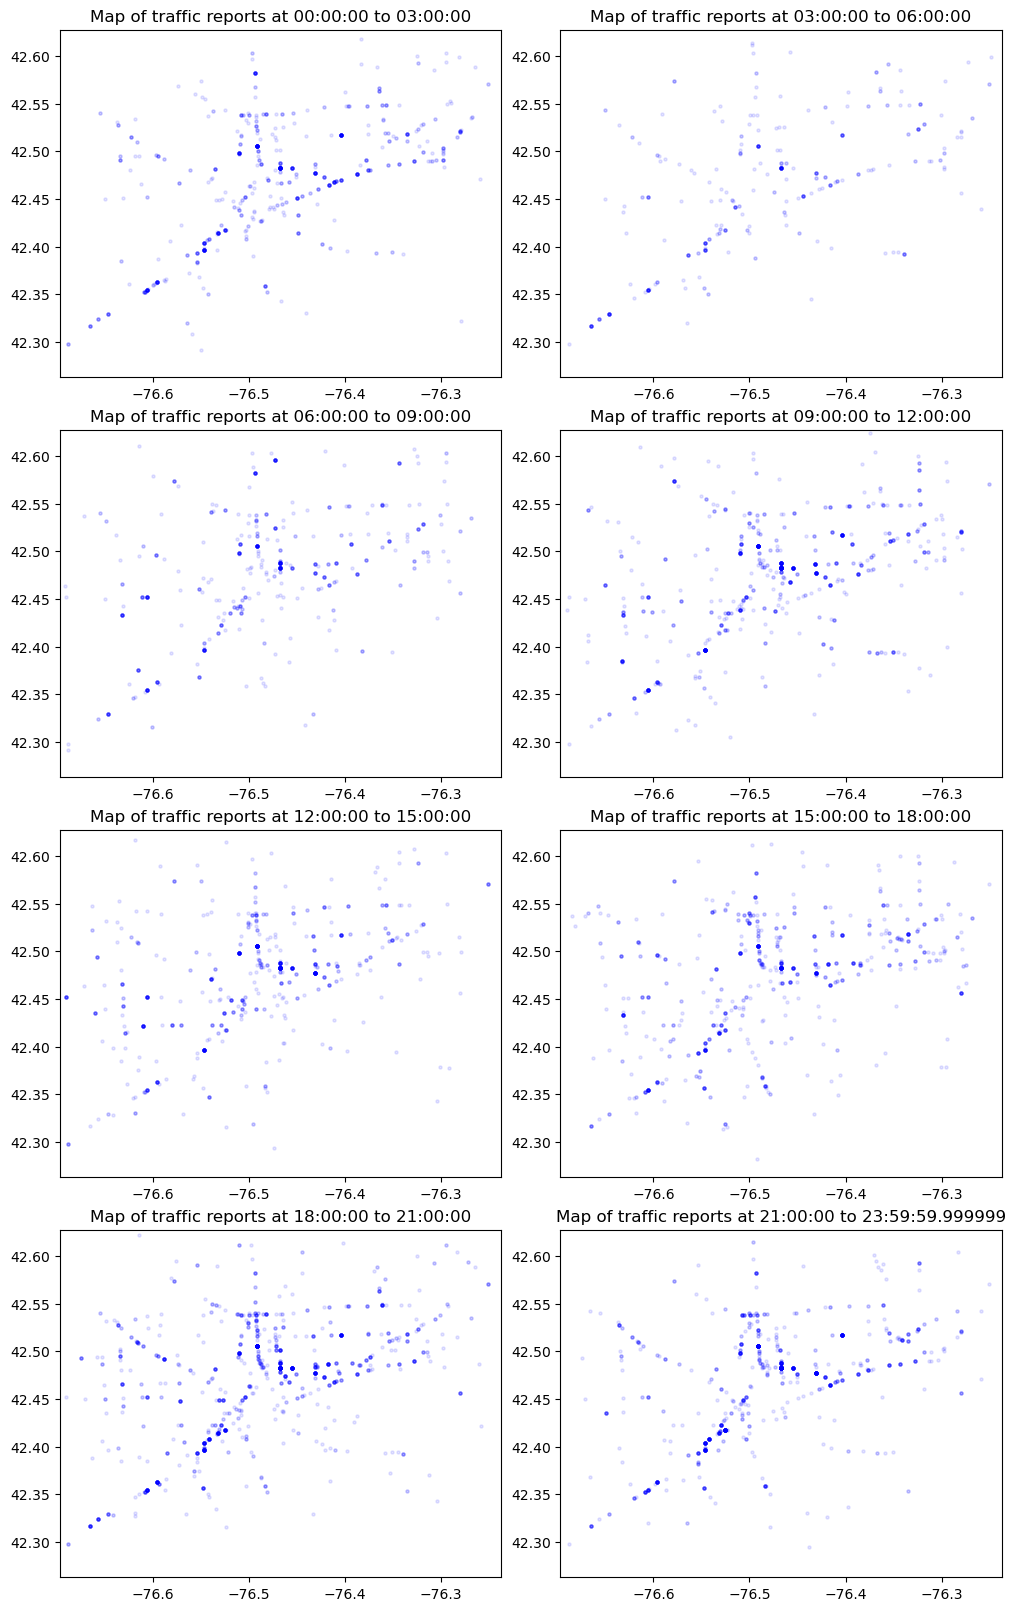

In [14]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 16),
                        layout="constrained")
df = pd.read_csv('whole_with_time.csv')
# add an artist, in this case a nice label in the middle...
for row in range(4):
    for col in range(2):

        ind = row * 2 + col
        start = datetime.time(ind * 3, 0, 0)
        end = datetime.time((ind + 1) * 3 % 24, 0, 0) if ind != 7 else datetime.time(hour=23, minute=59, second=59, microsecond=999999)

        print(start, end)

        df['time_started'] = pd.to_datetime(df['time_started'])
        tdf = df[(df['time_started'].dt.time <= end) & (df['time_started'].dt.time >= start)]
        axs[row, col].scatter(tdf.long, tdf.lat, zorder=1, alpha= 0.1, c='b', s=5)
        axs[row, col].set_title(f'Map of traffic reports at {start} to {end}')
        axs[row, col].set_xlim(bbox[0],bbox[1])
        axs[row, col].set_ylim(bbox[2],bbox[3])
        # axs[row, col].imshow(ruh_m, zorder=0, extent = bbox, aspect= 'equal')
# fig.suptitle('plt.subplots()')

2021-01-01 2021-02-01
2021-02-01 2021-03-01
2021-03-01 2021-04-01
2021-04-01 2021-05-01
2021-05-01 2021-06-01
2021-06-01 2021-07-01
2021-07-01 2021-08-01
2021-08-01 2021-09-01
2021-09-01 2021-10-01
2021-10-01 2021-11-01
2021-11-01 2021-12-01
2021-12-01 2022-01-01


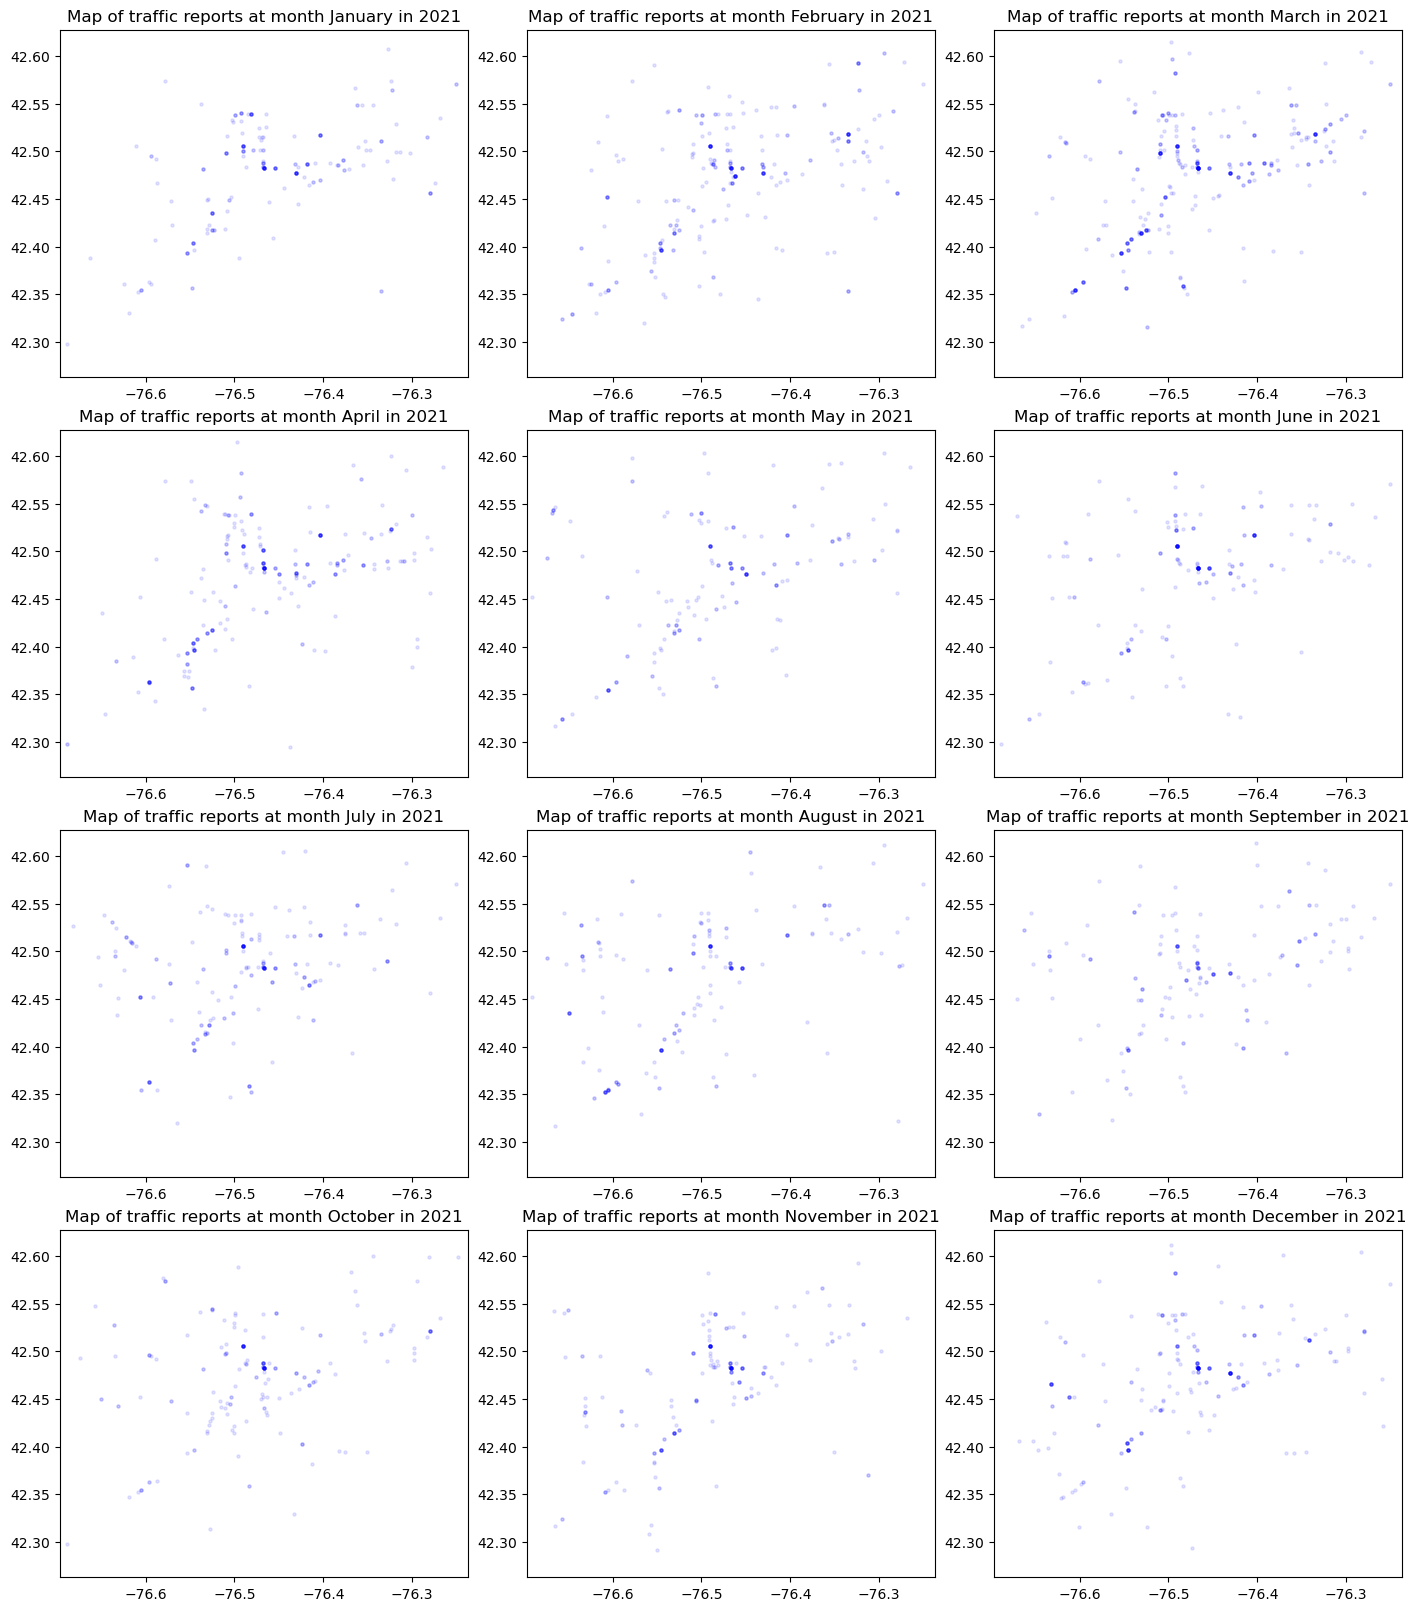

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(14, 16),
                        layout="constrained")
df = pd.read_csv('whole_with_time.csv')

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] 

for row in range(4):
    for col in range(3):

        ind = row * 3 + col

        start = datetime.date(2021, ind + 1, 1)
        end = datetime.date(2021, ind + 2, 1) if ind != 11 else datetime.date(2022, 1, 1)

        print(start, end)

        df['time_started'] = pd.to_datetime(df['time_started'])
        tdf = df[(df['time_started'].dt.date < end) & (df['time_started'].dt.date >= start)]
        axs[row, col].scatter(tdf.long, tdf.lat, zorder=1, alpha= 0.1, c='b', s=5)
        axs[row, col].set_title(f'Map of traffic reports at month {months[ind]} in 2021')
        axs[row, col].set_xlim(bbox[0],bbox[1])
        axs[row, col].set_ylim(bbox[2],bbox[3])
        # axs[row, col].imshow(ruh_m, zorder=0, extent = bbox, aspect= 'equal')
# fig.suptitle('plt.subplots()')

### Getting train, test, split

In [16]:
import datetime

df = pd.read_csv('whole_with_time.csv', index_col=0)
df['time_started'] = pd.to_datetime(df['time_started'])

first_nov = datetime.date(2022, 11, 1)
first_oct = datetime.date(2022, 10, 1)

tdf = df[(df['time_started'].dt.date < first_nov) | (df['time_started'].dt.date >= first_oct)]
tdf.to_csv('test.csv')

In [17]:
import datetime

df = pd.read_csv('whole_with_time.csv', index_col=0)
df['time_started'] = pd.to_datetime(df['time_started'])

end = datetime.date(2022, 10, 1)
start = datetime.date(2022, 7, 1)

tdf = df[(df['time_started'].dt.date < end) | (df['time_started'].dt.date >= start)]
tdf.to_csv('val.csv')

In [ ]:
import datetime

df = pd.read_csv('whole_with_time.csv', index_col=0)
df['time_started'] = pd.to_datetime(df['time_started'])

end = datetime.date(2022, 7, 1)

tdf = df[df['time_started'].dt.date < end]
tdf.to_csv('train.csv')